## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import re
import json
import sys
from tqdm import tqdm
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

import pytrec_eval
import numpy as np
import pandas as pd
from elasticsearch import Elasticsearch

from src.elastic_search_utils import elastic_utils

In [2]:
elastic_utils.ask_single_doc_id('d33811342')

{'d33811342': {'score': 1,
  'title': "Testing children with COVID-19 symptoms: what are parents' intentions?",
  'abstract': '',
  'mesh_terms': ['D000293:Adolescent',
   'D001315:Australia',
   'D000086382:COVID-19',
   'D000086742:COVID-19 Testing',
   'D002648:Child',
   'D002675:Child, Preschool',
   'D006801:Humans',
   'D033182:Intention',
   'D010290:Parents',
   'D000086402:SARS-CoV-2']}}

In [3]:
elastic_utils.get_single_question_metrics('what are the symptoms of Covid?')

{'documents': {'d33811342': {'score': 0.23228241,
   'title': "Testing children with COVID-19 symptoms: what are parents' intentions?",
   'abstract': '',
   'mesh_terms': ['D000293:Adolescent',
    'D001315:Australia',
    'D000086382:COVID-19',
    'D000086742:COVID-19 Testing',
    'D002648:Child',
    'D002675:Child, Preschool',
    'D006801:Humans',
    'D033182:Intention',
    'D010290:Parents',
    'D000086402:SARS-CoV-2']},
  'd33492244': {'score': 0.21754705000000002,
   'title': "Parkinson's Disease and the COVID-19 Pandemic.",
   'abstract': "Studies focusing on the relationship between severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), coronavirus disease 2019 (COVID-19), and Parkinson's disease (PD) have provided conflicting results. We review the literature to investigate: 1) Are PD patients at higher risk for contracting COVID-19 and are there specific contributing factors to that risk? 2) How does COVID-19 affect PD symptoms? 3) How does COVID-19 present in P

## Params

In [4]:
ELASTIC_SERVER = "http://localhost:9200"
QUESTIONS_PATH = "/home/azuluagac/DR_tests/training9b.json"
N_ANSWERS = 100
SEARCH_FIELDS = ['title', 'abstract', 'mesh_terms']
SEARCH_INDEX = 'pubmed2022_index_full'

SAVING_PATH_TRAINING = '/datasets/johan_tests/training_docs.json'
SAVING_PATH_ASKED = '/datasets/johan_tests/queried_docs.json'

## Constants

In [5]:
es = Elasticsearch(ELASTIC_SERVER)

In [6]:
questions = elastic_utils.load_questions(QUESTIONS_PATH)

In [7]:
count_docs = [len(question['documents']) for question in questions]

In [8]:
pd.Series(count_docs).describe()

count    3743.000000
mean        9.426930
std         9.927285
min         1.000000
25%         3.000000
50%         7.000000
75%        13.000000
max       157.000000
dtype: float64

In [9]:
pd.Series(count_docs).quantile(0.90)

21.0

/datasets/anaconda3/envs/tf2.8/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

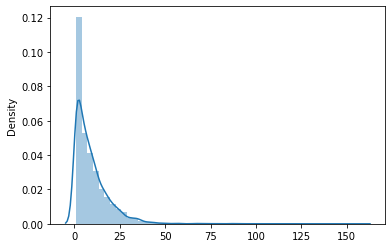

In [10]:
sns.distplot(count_docs)

## Making gold standard
### Making base gold standard dict

In [11]:
gold_standard = elastic_utils.make_gold_standard(questions)

Making base gold standard: 100%|████████| 3743/3743 [00:00<00:00, 231706.59it/s]


## Extracting abstracts and titles from question documents 
### Unique documents

In [12]:
unique_documents = elastic_utils.extract_all_document_ids(
    questions
)
len(unique_documents)

Document id extraction: 100%|███████████| 3743/3743 [00:00<00:00, 308191.60it/s]


35285

### Querying documents 

In [13]:
doc_ans = elastic_utils.ask_all_doc_id(unique_documents, SEARCH_FIELDS, es, SEARCH_INDEX)

Querying training document ids: 100%|████| 35285/35285 [02:19<00:00, 252.60it/s]


In [14]:
print('WTF')

WTF


### Changing gold standard to have document info

In [15]:
elastic_utils.add_doc_info_to_gold_standard(gold_standard, doc_ans)

Adding doc info to gold standard: 100%|█| 3743/3743 [00:00<00:00, 450132.75it/s]


## Making answers for training

### Single answer example

In [16]:
sample_answers = elastic_utils.ask_single_question(
    question=questions[0],
    fields=SEARCH_FIELDS,
    size=N_ANSWERS,
    es_client=es,
    index=SEARCH_INDEX
)

In [17]:
sample_answers.keys()

dict_keys(['took', 'timed_out', '_shards', 'hits'])

In [18]:
pprint(sample_answers['hits']['hits'][0])

{'_id': 'iqv2sn8B1o02LKX0RqIC',
 '_ignored': ['abstract.keyword'],
 '_index': 'pubmed2022_index_full',
 '_score': 34.236095,
 '_source': {'abstract': 'Hirschsprung disease is a congenital disorder with '
                         'the incidence of 1 per 5000 live births, '
                         'characterized by the absence of intestinal ganglion '
                         'cells. In the etiology of Hirschsprung disease '
                         'various genes play a role; these are: RET, EDNRB, '
                         'GDNF, EDN3 and SOX10, NTN3, ECE1, Mutations in these '
                         'genes may result in dominant, recessive or '
                         'multifactorial patterns of inheritance. Diverse '
                         'models of inheritance, co-existence of numerous '
                         'genetic disorders and detection of numerous '
                         'chromosomal aberrations together with involvement of '
                         'various gen

In [19]:
single_metrics = elastic_utils.answers_to_id_metric(
    sample_answers
)

In [20]:
single_metrics

{'d15858239': 0.34236095,
 'd11106284': 0.33183098,
 'd3578280': 0.32416817000000003,
 'd10893883': 0.31942066,
 'd30954460': 0.29275568,
 'd23465774': 0.29030823,
 'd22475248': 0.28305304,
 'd9600737': 0.27977608,
 'd12239580': 0.2739651,
 'd8877363': 0.27115635,
 'd27639057': 0.27113972000000003,
 'd16986122': 0.27096252,
 'd27370713': 0.26820717,
 'd9465697': 0.26786556,
 'd9174404': 0.26709528,
 'd30924549': 0.26574312,
 'd33768880': 0.26484543,
 'd29677472': 0.26441075999999997,
 'd18472352': 0.26373466,
 'd7634536': 0.26270704,
 'd12699256': 0.25905737,
 'd155240': 0.25807156,
 'd11949952': 0.25774113,
 'd9090527': 0.25615469999999996,
 'd28855933': 0.25602615,
 'd29018668': 0.25559172,
 'd26228106': 0.2547941,
 'd31313802': 0.25457567000000003,
 'd11108911': 0.2541384,
 'd33151932': 0.25409756,
 'd22307701': 0.25337666999999997,
 'd10407683': 0.25251139,
 'd10395219': 0.25162148,
 'd3051535': 0.25158342,
 'd31666091': 0.25097816,
 'd14689098': 0.25064047,
 'd12189494': 0.2505851

### Multiple question answering

In [ ]:
%%time
multiple_ans = elastic_utils.ask_several_questions(
    questions=questions,
    fields=SEARCH_FIELDS,
    size=N_ANSWERS,
    es_client=es,
    index=SEARCH_INDEX
)

Extracting docs from elastic search:  10%|▎  | 361/3743 [01:30<16:19,  3.45it/s]

## Saving dicts

In [ ]:
elastic_utils.save_json(gold_standard, SAVING_PATH_TRAINING)
elastic_utils.save_json(multiple_ans, SAVING_PATH_ASKED)